In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing
# read in csv
df1 = pd.read_csv("source/ED 2020.csv")
df2 = pd.read_csv("source/2020 INPATIENT.csv")

In [ ]:
# define cols with diagnosis codes
othdiag = [col for col in df1.columns if 'OTHDIAG' in col]
ed_diag_cols = ['REASON_CDE', 'PRINDIAG'] + othdiag

othdiag = [col for col in df2.columns if 'OTHDIAG' in col]
inpt_diag_cols = ['ADMITDIAG', 'PRINDIAG'] + othdiag

# define regex for filtering ADRD ICD10 codes
adrd_pattern = r'^F0[12]\.(5[01]|8[01]).*'

# filter dataframe for rows with ADRD diagnosis codes
df1_filtered = df1[df1[ed_diag_cols].apply(lambda x: x.str.contains(adrd_pattern, na=False)).any(axis=1)]
df2_filtered = df2[df2[inpt_diag_cols].apply(lambda x: x.str.contains(adrd_pattern, na=False)).any(axis=1)]

In [ ]:
# apply Z-present flag to filtered dataframe
df1 = df1_filtered[ed_diag_cols]
df1 = df1.assign(
    z_present = df1.apply(lambda col: col.str.startswith('Z', na=False)).any(axis=1))

# switch to long format
df1_long = df1.melt(var_name='dx_field', value_name='dx_code').dropna(subset=['dx_code'])

# filter rows with Z-codes only
df1_long = df1_long[df1_long['dx_code'].str.startswith('Z', na=False)]

# count occurrences per dx_field/code
z_counts = df1_long.groupby(['dx_field', 'dx_code'], as_index=False).size().rename(columns={'size': 'count'})

# keep only codes with count > 5
z_counts = z_counts[z_counts['count'] > 5]

# top 5 / bottom 5 per diagnosis column
ED_top_bottom = pd.concat([
    z_counts.groupby('dx_field', group_keys=False).apply(lambda x: x.nlargest(5, 'count')),
    z_counts.groupby('dx_field', group_keys=False).apply(lambda x: x.nsmallest(5, 'count'))
], ignore_index=True)

# summary row for non-Z encounters
no_z_count = len(df1) - df1['z_present'].sum()
no_z_row = pd.DataFrame({'dx_field': ['NONE'], 'dx_code': ['No Z-codes present'], 'count': [no_z_count]})
ED_final_table = pd.concat([ED_top_bottom, no_z_row], ignore_index=True)

# overall top 10 Z-codes across all columns
overall_counts = df1_long['dx_code'].value_counts().reset_index()
overall_counts.columns = ['dx_code', 'count']
ED_overall_top10 = overall_counts.head(10)
ED_overall_top10 = pd.concat([
    ED_overall_top10,
    pd.DataFrame([{'dx_code': 'No Z-codes present', 'count': no_z_count}])
], ignore_index=True)

# export tables
ED_final_table.to_csv("ED_top_bottom_per_column.csv", index=False)
ED_overall_top10.to_csv("ED_top10_overall.csv", index=False)


C:\Users\grgil\AppData\Local\Temp\ipykernel_9804\1364097259.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = ED_top_bottom.groupby('dx_field', group_keys=False).apply(lambda x: x.nlargest(5, 'count'))


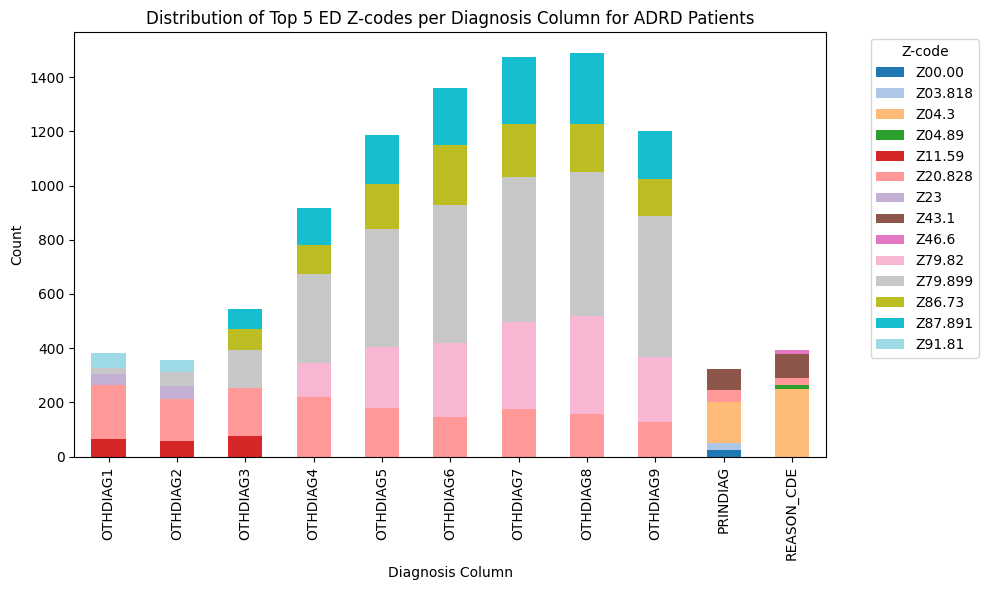

In [7]:
# keep only top 5 per diagnosis column
top5 = ED_top_bottom.groupby('dx_field', group_keys=False).apply(lambda x: x.nlargest(5, 'count'))

# pivot to wide format: rows = dx_field, columns = dx_code, values = count
pivot = top5.pivot(index='dx_field', columns='dx_code', values='count').fillna(0)

# plot stacked bar chart
pivot.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.ylabel('Count')
plt.xlabel('Diagnosis Column')
plt.title('Distribution of Top 5 ED Z-codes per Diagnosis Column for ADRD Patients')
plt.legend(title='Z-code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# apply Z-present flag to filtered dataframe
df2 = df2_filtered[inpt_diag_cols]
df2 = df2.assign(
    z_present = df2.apply(lambda col: col.str.startswith('Z', na=False)).any(axis=1))

# switch to long format
df2_long = df2.melt(var_name='dx_field', value_name='dx_code').dropna(subset=['dx_code'])

# filter rows with Z-codes only
df2_long = df2_long[df2_long['dx_code'].str.startswith('Z', na=False)]

# count occurrences per dx_field/code
z_counts = df2_long.groupby(['dx_field', 'dx_code'], as_index=False).size().rename(columns={'size': 'count'})

# keep only codes with count > 5
z_counts = z_counts[z_counts['count'] > 5]

# top 5 / bottom 5 per diagnosis column
INPT_top_bottom = pd.concat([
    z_counts.groupby('dx_field', group_keys=False).apply(lambda x: x.nlargest(5, 'count')),
    z_counts.groupby('dx_field', group_keys=False).apply(lambda x: x.nsmallest(5, 'count'))
], ignore_index=True)

# summary row for non-Z encounters
no_z_count = len(df2) - df2['z_present'].sum()
no_z_row = pd.DataFrame({'dx_field': ['NONE'], 'dx_code': ['No Z-codes present'], 'count': [no_z_count]})
INPT_final_table = pd.concat([INPT_top_bottom, no_z_row], ignore_index=True)

# overall top 10 Z-codes across all columns
overall_counts = df2_long['dx_code'].value_counts().reset_index()
overall_counts.columns = ['dx_code', 'count']
INPT_overall_top10 = overall_counts.head(10)
INPT_overall_top10 = pd.concat([
    INPT_overall_top10,
    pd.DataFrame([{'dx_code': 'No Z-codes present', 'count': no_z_count}])
], ignore_index=True)

# export tables
INPT_final_table.to_csv("INPT_top_bottom_per_column.csv", index=False)
INPT_overall_top10.to_csv("INPT_top10_overall.csv", index=False)


C:\Users\grgil\AppData\Local\Temp\ipykernel_9804\835566760.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = INPT_top_bottom.groupby('dx_field', group_keys=False).apply(lambda x: x.nlargest(5, 'count'))


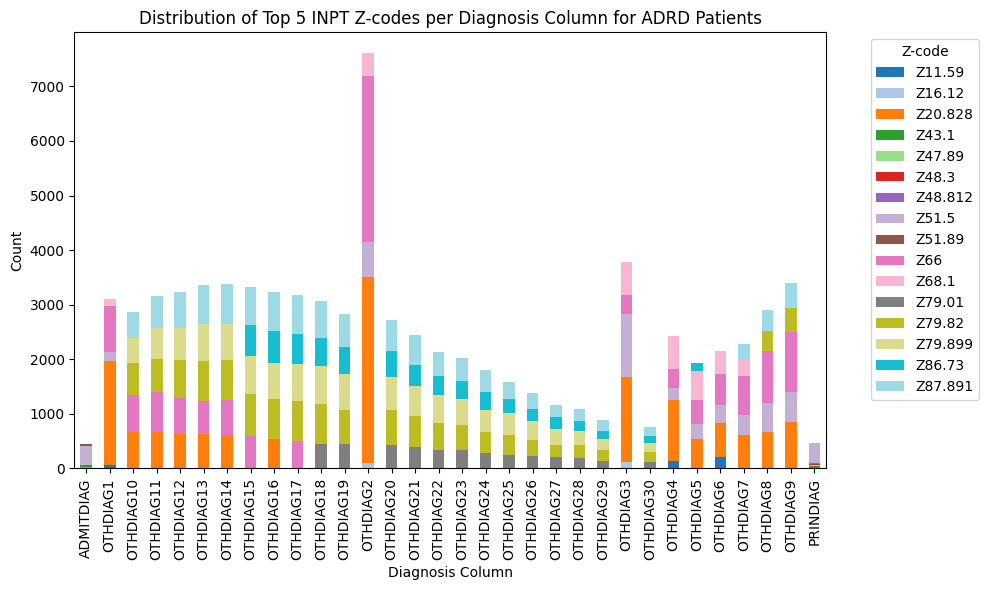

In [6]:
# keep only top 5 per diagnosis column
top5 = INPT_top_bottom.groupby('dx_field', group_keys=False).apply(lambda x: x.nlargest(5, 'count'))

# pivot to wide format: rows = dx_field, columns = dx_code, values = count
pivot = top5.pivot(index='dx_field', columns='dx_code', values='count').fillna(0)

# plot stacked bar chart
pivot.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.ylabel('Count')
plt.xlabel('Diagnosis Column')
plt.title('Distribution of Top 5 INPT Z-codes per Diagnosis Column for ADRD Patients')
plt.legend(title='Z-code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
